In [38]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import MobileNetV2
from imutils import paths
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import cv2
import os
import seaborn as sns

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [4]:
#from tensorflow.keras.applications import VGG19
#from tensorflow.keras.applications.vgg19 import preprocess_input

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [25]:
# инициализировать количество эпох для тренировки, начальную скорость обучения,
# размер пакета и размеры изображения
EPOCHS = 100
INIT_LR = 1e-4 #начальнаня скорость обучения
BS = 32 #контролирует размер пакетов передаваемых на обучение
IMAGE_DIMS = (256, 256, 3) # размеры изображения и 3х канальный RGB

# инициализируем данные и метки
data = []
labels = []

# захватываем пути изображения и случайным образом перемешиваем их
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images("Flowers")))
random.seed(42)
random.shuffle(imagePaths)

[INFO] loading images...


In [26]:
#Перебираем изображения 
for imagePath in imagePaths:
    
    # загружаем изображение, предварительно обработать его и сохранив в списке данных
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image) #  преобразования изображения в массив, совместимый с Keras
    data.append(image)
    
    # извлекаем метку класса из пути к изображению и обновляем
    # список ярлыков
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [27]:
print(np.array(data).shape)

(935, 256, 256, 3)


In [28]:
# Считывание меток
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#labels = to_categorical(labels)

# масштабировать яркость необработанных пикселей в диапазоне [0, 1]
data = np.array(data, dtype="float")
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 1436.16MB


In [29]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [30]:
(trainX, testX, trainY, testY) = train_test_split(preprocess_input(data),
    labels, test_size=0.2, random_state = 42)

In [31]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

### Загружаем сеть

In [32]:
base_model = ResNet50(include_top = False, weights = 'imagenet', input_shape = IMAGE_DIMS)

In [33]:
model_layers = base_model.output
model_layers = GlobalAveragePooling2D()(model_layers)
model_layers = Dense(1024, activation="relu")(model_layers)
model_layers = Dense(25, activation='softmax')(model_layers)

model = Model(inputs = base_model.input, outputs=model_layers)

In [34]:
for layer in base_model.layers:
    layer.trainable = False

In [35]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [36]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

In [39]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='min')

In [40]:
#Сделать эпох больше чем шагов  validation_steps steps_per_epoch
history = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    callbacks=[learning_rate_reduction,early_stopping])

Epoch 1/100
18/23 [======================>.......] - ETA: 10s - loss: 0.3868 - accuracy: 0.9245

KeyboardInterrupt: 

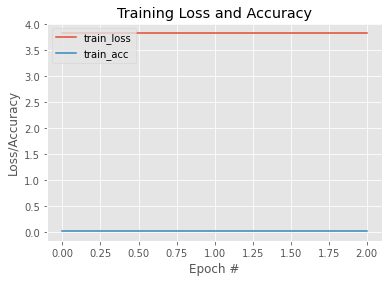

In [29]:
# График точности и потерь при обучении
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()

In [30]:
model_res.save('Transfer_1.h5')

c:\users\misha\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [61]:
from tensorflow.keras.models import load_model

In [62]:
model_res = load_model('Transfer.h5')

In [63]:
prediction = model_res.predict(testX)

In [64]:
test_loss, test_acc = model_res.evaluate(testX, testY)
print("Test loss: {}, Test Accuracy {}".format(test_loss, test_acc))

6/6 [==============================] - 13s 2s/step - loss: 0.1280 - accuracy: 0.9572
Test loss: 0.12803025543689728, Test Accuracy 0.9572192430496216


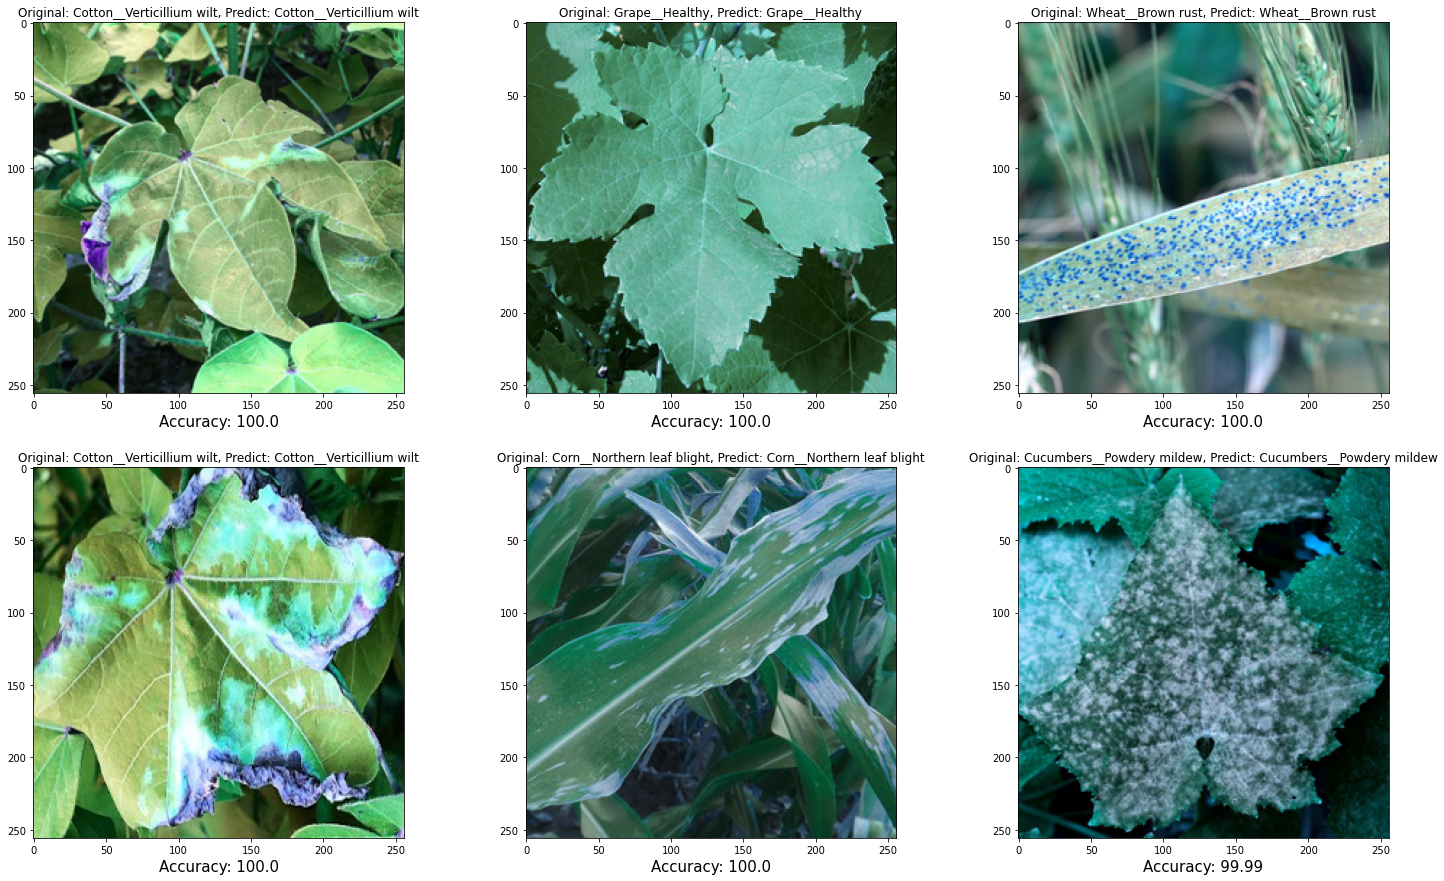

In [73]:
plt.figure(figsize=(25,15))
columns = 5
for i in range(0, 6):
    accuracy = round(prediction[i][np.argmax(prediction[i])]*100, 2)
    plt.subplot(2, 3, i + 1)
    plt.imshow(testX[i])
    plt.title("Original: {}, Predict: {}".format(lb.inverse_transform(testY)[i], lb.inverse_transform(prediction)[i],), size=12)
    plt.xlabel("Accuracy: {}".format(accuracy), size=15)

# Другая тестовая выборка

In [74]:
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images("test_base")))

[INFO] loading images...


In [75]:
test_base = []
labels_test = []
#Перебираем изображения 
for imagePath in imagePaths:
    
    # загружаем изображение, предварительно обработать его и сохранив в списке данных
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image) #  преобразования изображения в массив, совместимый с Keras
    test_base.append(image)
    
    label = imagePath.split(os.path.sep)[-2]
    labels_test.append(label)

In [76]:
labels_test = np.array(labels_test)

# Считывание меток
lb = LabelBinarizer()
labels_test = lb.fit_transform(labels_test)

In [77]:
test_base = np.array(test_base, dtype="float") / 255.0

In [78]:
prediction_test = model_res.predict([test_base])

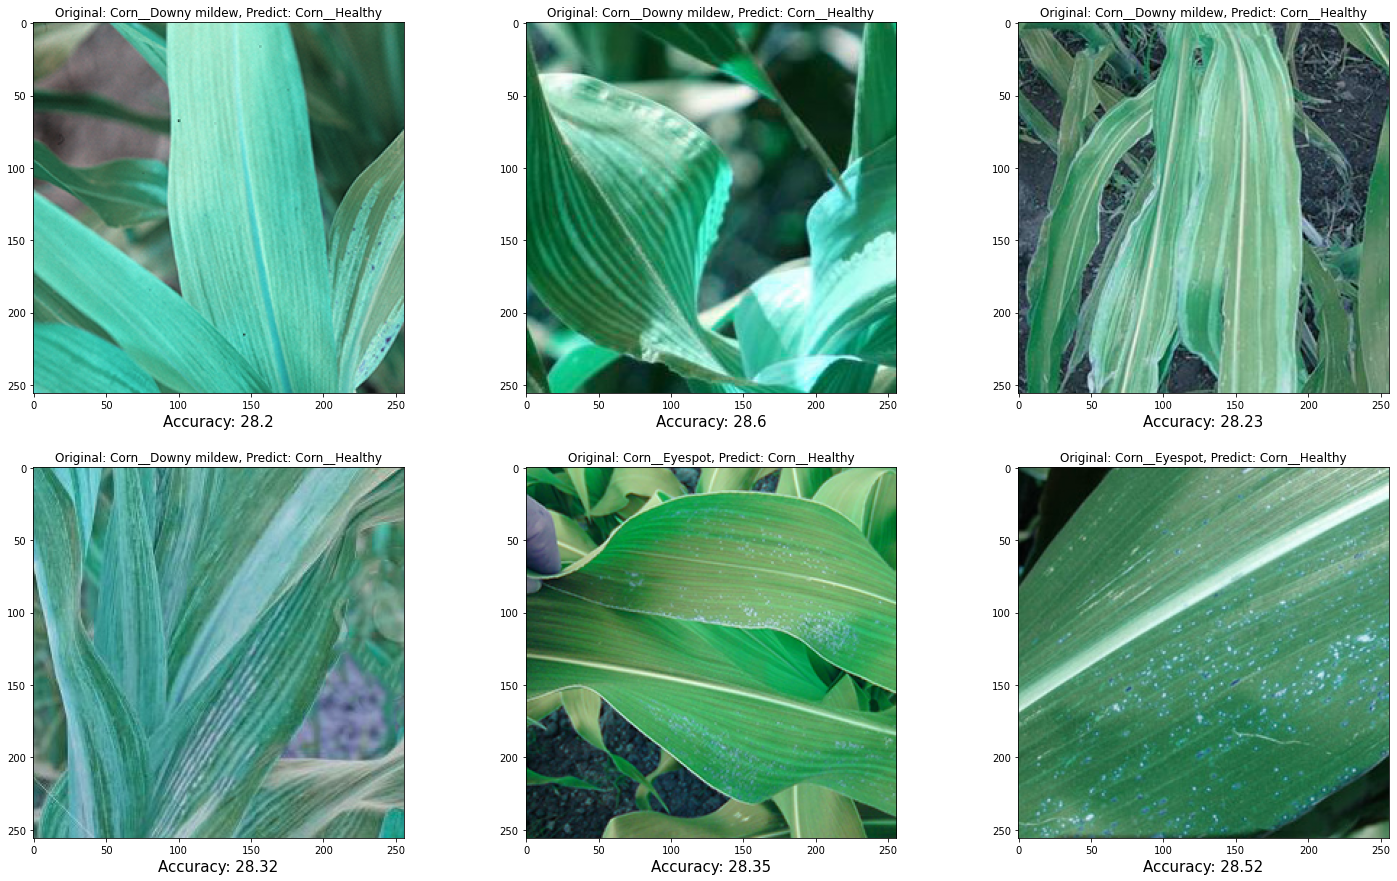

In [92]:
plt.figure(figsize=(25,15))
columns = 5
for i in range(0, 6):
    accuracy = round(prediction_test[i][np.argmax(prediction_test[i])]*100, 2)
    plt.subplot(2, 3, i + 1)
    plt.imshow(test_base[i])
    plt.title("Original: {}, Predict: {}".format(lb.inverse_transform(labels_test)[i], lb.inverse_transform(prediction_test)[i],), size=12)
    plt.xlabel("Accuracy: {}".format(accuracy), size=15)

# Создание DF

In [80]:
pred = lb.inverse_transform(prediction)
pred = pd.DataFrame({'predict': pred})

In [81]:
truth = lb.inverse_transform(testY)
truth = pd.DataFrame({'truth': truth})

In [82]:
final = truth.join(pred)

In [83]:
final.to_csv('Prediction_trans.csv', index=False)

In [84]:
final = pd.read_csv("Prediction_trans.csv")
classes = final.truth.unique()
classes.sort()

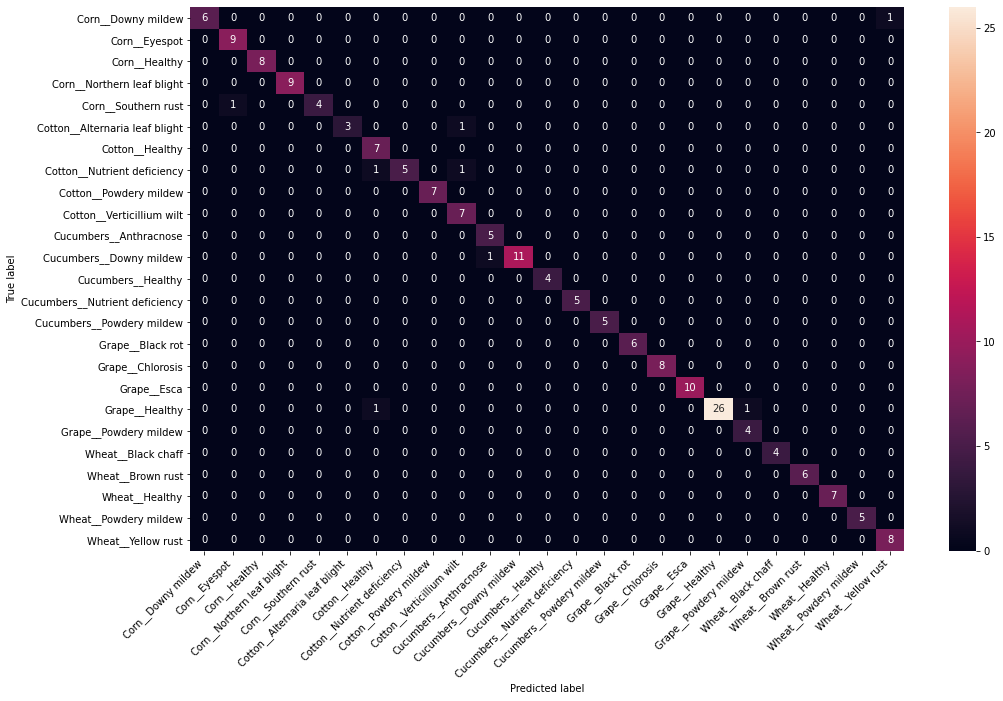

In [85]:
conf_matrix = confusion_matrix(lb.inverse_transform(testY), lb.inverse_transform(prediction))

df = pd.DataFrame(conf_matrix, index=classes, columns=classes, )

fig, ax = plt.subplots(figsize=(16, 10))
ax = sns.heatmap(df, annot = True, fmt = 'd', ax = ax)
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [86]:
pred = lb.inverse_transform(prediction_test)
pred = pd.DataFrame({'predict': pred})

In [87]:
truth = lb.inverse_transform(labels_test)
truth = pd.DataFrame({'truth': truth})

In [88]:
final = truth.join(pred)

In [89]:
final.to_csv('Prediction_test_trans.csv', index=False)

In [90]:
final = pd.read_csv("Prediction_test_trans.csv")
classes = final.truth.unique()
classes.sort() 

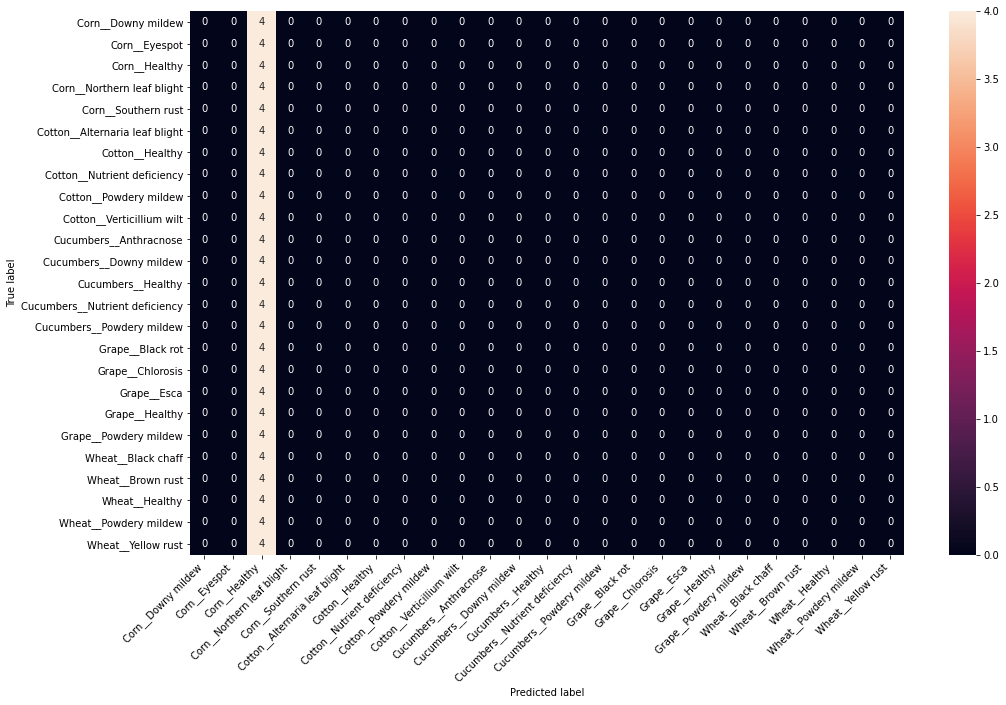

In [91]:
conf_matrix = confusion_matrix(lb.inverse_transform(labels_test), lb.inverse_transform(prediction_test))

df = pd.DataFrame(conf_matrix, index=classes, columns=classes, )

fig, ax = plt.subplots(figsize=(16, 10))
ax = sns.heatmap(df, annot = True, fmt = 'd', ax = ax)
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()